In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
features, labels = [], []
training_files = ["../dataset/individual/icmp_dataset_individual_attack_3detik_1.csv",
                  "../dataset/individual/icmp_dataset_individual_normal_3detik_1.csv"]

In [3]:
def scrape_data():
    global training_files
    global features
    global labels
    
    for fname in training_files:
        meal = open(fname, "rt")
        for line in meal:
            data_list = line.rsplit(",")
            if(len(data_list) != 8):
                print("error data")
            else:
                data_list[(len(data_list)-1)]=int(data_list[(len(data_list)-1)].replace('\n', ''))
                features.append(data_list[:(len(data_list)-1)])
                labels.append(data_list[(len(data_list)-1)])
        meal.close()
    
    data_counter = Counter(labels)
    print(data_counter)
    
    over = SMOTE()
    under = RandomUnderSampler()
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    features, labels = pipeline.fit_resample(features, labels)
    
    data_counter = Counter(labels)
    print(data_counter)
    
    scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
    scalar.fit(features)
    features = scalar.transform(features)
    
    features = np.array(features).astype(np.float64)
    features = features.tolist()
    
    print(f"Size of feature dataset : {len(features)}")
    print(f"Size of feature dataset : {len(labels)}")
    print("Features first and last entries:\n\t", end = "")
    print(features[:1] + features[(len(features)-1):])
    print("Labels first and last entries:\n\t", end = "")
    print(labels[:1] + labels[(len(features)-1):])
    
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.20, stratify=labels, random_state = 0)
    
    return np.asarray(features_train), np.asarray(labels_train), np.asarray(features_test), np.asarray(labels_test)

In [4]:
def generate_model(shape):
    model = Sequential()

    model.add(Dense(256, input_dim=shape, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())

    return model

In [5]:
data_train, label_train, data_eval, label_eval = scrape_data()

Counter({0: 496, 1: 162})
Counter({0: 496, 1: 496})
Size of feature dataset : 992
Size of feature dataset : 992
Features first and last entries:
	[[-0.9223494588612416, -0.6340551766312511, -2.1183037221500083, -0.579900767782616, -1.029343156848407, -0.4059212210980578, -0.8167423808890334], [0.1083383131939551, -0.6340551766312511, 0.6947904235011645, -0.579900767782616, 1.0266725998868287, -0.4059212210980578, -0.6942676527541763]]
Labels first and last entries:
	[0, 1]


C:\Users\H P VICTUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(


In [6]:
model = generate_model(len(data_train[0]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
checkpoint = ModelCheckpoint("dnnModel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')

In [10]:
history = model.fit(data_train, label_train, validation_split=0.2, epochs=100, verbose = 1, callbacks=[checkpoint,early])

Epoch 1/100
19/20 [===========================>..] - ETA: 0s - loss: 0.5841 - accuracy: 0.7007 
Epoch 00001: val_loss improved from inf to 0.35293, saving model to dnnModel.h5
20/20 [==============================] - 1s 9ms/step - loss: 0.5738 - accuracy: 0.7114 - val_loss: 0.3529 - val_accuracy: 0.9874
Epoch 2/100
19/20 [===========================>..] - ETA: 0s - loss: 0.2520 - accuracy: 0.9507
Epoch 00002: val_loss improved from 0.35293 to 0.04764, saving model to dnnModel.h5
20/20 [==============================] - 0s 6ms/step - loss: 0.2454 - accuracy: 0.9527 - val_loss: 0.0476 - val_accuracy: 1.0000
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9921
Epoch 00003: val_loss improved from 0.04764 to 0.00254, saving model to dnnModel.h5
20/20 [==============================] - 0s 5ms/step - loss: 0.0875 - accuracy: 0.9921 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 4/100
19/20 [===========================>..] - ETA: 0s - loss: 0.0567 - a

Epoch 30/100
17/20 [========================>.....] - ETA: 0s - loss: 0.0060 - accuracy: 0.9982    
Epoch 00030: val_loss did not improve from 0.00014
20/20 [==============================] - 0s 5ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 31/100
18/20 [==========================>...] - ETA: 0s - loss: 0.0061 - accuracy: 0.9965
Epoch 00031: val_loss did not improve from 0.00014
20/20 [==============================] - 0s 5ms/step - loss: 0.0056 - accuracy: 0.9968 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 32/100
18/20 [==========================>...] - ETA: 0s - loss: 0.0031 - accuracy: 0.9983    
Epoch 00032: val_loss did not improve from 0.00014
20/20 [==============================] - 0s 4ms/step - loss: 0.0116 - accuracy: 0.9953 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 33/100
16/20 [=======================>......] - ETA: 0s - loss: 0.0047 - accuracy: 0.9980    
Epoch 00033: val_loss did not improve from 0.00014
20/20 [======

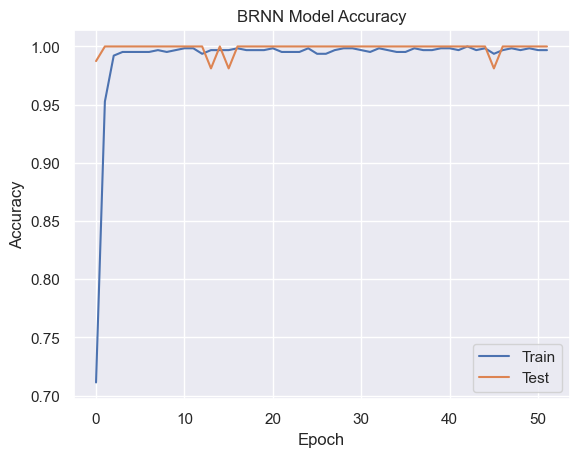

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
# plt.savefig('BRNN 200 Model Accuracy.png')
plt.show()

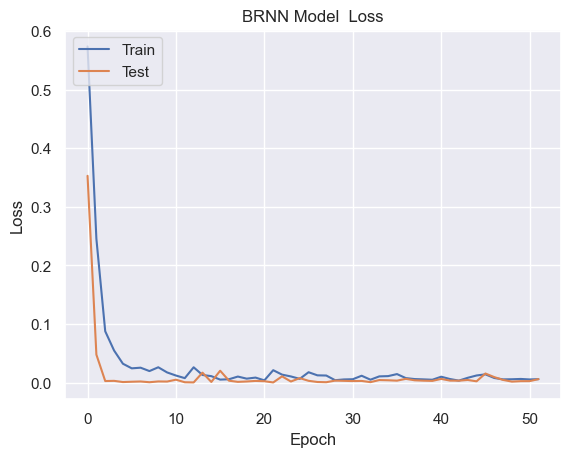

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('BRNN 200 Model Loss.png')
plt.show()

In [13]:
predict = model.predict(data_eval, verbose=1)

7/7 [==============================] - 0s 1ms/step


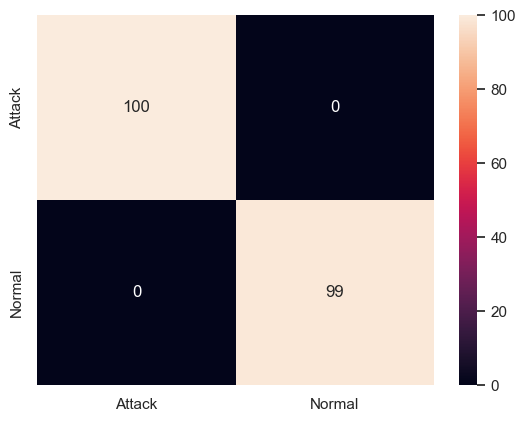

In [14]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = label_eval.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [15]:
scores = model.evaluate(data_eval, label_eval)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

7/7 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000
accuracy: 100.00%


In [16]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        99

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199



In [17]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=1.000


In [18]:
time_start = time.perf_counter()
predict = model.predict(data_eval[:1], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

1/1 [==============================] - 0s 12ms/step
Time elapse for prediction : 0.031510900000000674
[[1.6442762e-05]]
